In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from IPython.display import display

In [2]:
def on_kaggle() -> bool:
    try:
        import gresearch_crypto
        return True
    except ModuleNotFoundError:
        return False

In [3]:
# HYPER PARAMETERS
ON_KAGGLE = on_kaggle()
USE_SAMPLE = True
USE_TOY_SAMPLE = True

# DATASET DTYPES FOR SAVING MEMORY
DTYPES = {'Asset_ID': 'int32',
          'Open': 'float32',
          'High': 'float32',
          'Low': 'float32',
          'Close': 'float32',
          'VWAP': 'float32'}



In [4]:
if not ON_KAGGLE and os.path.abspath('.').endswith('notebook'):
    os.chdir('../')

In [12]:
if ON_KAGGLE:
    RAW_DIR = Path('../input/g-research-crypto-forecasting/')
    SAMPLE_DIR = Path('../input/create-sample-dataset/data/raw/sample/')
    TOY_SAMPLE_DIR = Path('../input/create-sample-dataset/data/raw/toy_sample/')
else:
    RAW_DIR =  Path('data/raw')
    TOY_SAMPLE_DIR = RAW_DIR.joinpath('toy_sample')
    SAMPLE_DIR = RAW_DIR.joinpath('sample')

# filename
TRAIN_FILE = 'train.csv'

In [14]:
if USE_TOY_SAMPLE:
    RAW_TRAIN_PATH = TOY_SAMPLE_DIR / TRAIN_FILE

elif USE_SAMPLE:
    RAW_TRAIN_PATH = SAMPLE_DIR / TRAIN_FILE

else:
    RAW_TRAIN_PATH = RAW_DIR / TRAIN_FILE

assert RAW_TRAIN_PATH.exists()

In [7]:
!ls {RAW_DIR}

asset_details.csv		   sample
example_sample_submission.csv	   supplemental_train.csv
example_test.csv		   toy_sample
g-research-crypto-forecasting.zip  train.csv
gresearch_crypto


In [10]:
date_parser = lambda date: pd.to_datetime(date, unit='s')

In [11]:
%%time 
raw_df = pd.read_csv(RAW_TRAIN_PATH,
                     parse_dates=['timestamp'],
                     date_parser=date_parser,
                     dtype=DTYPES)

CPU times: user 1.28 s, sys: 97.1 ms, total: 1.38 s
Wall time: 1.44 s


In [12]:
asset_details = pd.read_csv(RAW_DIR / 'asset_details.csv')

In [13]:
raw_df = raw_df.merge(asset_details[['Asset_ID', 'Asset_Name']], on='Asset_ID', how='left')

In [14]:
raw_df.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,Asset_Name
0,2021-09-01 00:01:00,3,609.0,2.764178,2.766900,2.761000,2.764524,2.097173e+05,2.764590,-0.002807,Cardano
1,2021-09-01 00:01:00,2,174.0,635.166016,635.909973,634.700012,635.343994,1.757762e+02,635.349670,-0.000726,Bitcoin Cash
2,2021-09-01 00:01:00,0,373.0,462.223511,463.300995,462.200012,463.005493,8.652694e+02,462.689636,0.002667,Binance Coin
3,2021-09-01 00:01:00,1,2498.0,47067.851562,47099.000000,47029.500000,47070.906250,6.578534e+01,47068.238281,0.000824,Bitcoin
4,2021-09-01 00:01:00,4,771.0,0.277157,0.277900,0.276825,0.277348,2.166510e+06,0.277271,-0.000951,Dogecoin


In [15]:
raw_df.shape

(403142, 11)

In [16]:
raw_df.drop(['timestamp', 'Asset_ID', 'Asset_ID'], axis=1).describe()

,Count,Open,High,Low,Close,Volume,VWAP,Target
count,403142.000000,403142.000000,403142.000000,403142.000000,403142.000000,4.031420e+05,403142.000000,402821.000000
mean,563.002473,3997.078857,4000.597168,3993.382324,3997.069336,3.797510e+05,3997.023193,-0.000002
std,1248.397555,12180.674805,12190.963867,12169.887695,12180.648438,1.602194e+06,12180.515625,0.003982
min,1.000000,0.078303,0.081270,0.075608,0.078168,9.610000e-06,0.078358,-0.066437
25%,92.000000,1.528000,1.553700,1.503800,1.528000,1.442321e+02,1.527917,-0.001415
50%,231.000000,76.630608,76.795452,76.518501,76.642403,1.445653e+03,76.650890,-0.000081
75%,593.000000,644.417114,644.940002,643.917480,644.423508,1.284157e+05,644.411758,0.001253
max,83287.000000,52884.414062,52956.468750,52856.039062,52882.093750,1.257849e+08,52898.320312,0.211227


In [17]:
100 * raw_df.isna().mean() # number of nans %

timestamp     0.000000
Asset_ID      0.000000
Count         0.000000
Open          0.000000
High          0.000000
Low           0.000000
Close         0.000000
Volume        0.000000
VWAP          0.000000
Target        0.079625
Asset_Name    0.000000
dtype: float64

# date 

In [21]:
date_range = raw_df.groupby('Asset_Name')['timestamp'].agg(('min', 'max'))

In [22]:
date_range.sort_values(by='min')

,min,max
Asset_Name,,
Binance Coin,2021-09-01 00:01:00,2021-09-21
Bitcoin,2021-09-01 00:01:00,2021-09-21
Bitcoin Cash,2021-09-01 00:01:00,2021-09-21
Cardano,2021-09-01 00:01:00,2021-09-21
Dogecoin,2021-09-01 00:01:00,2021-09-21
EOS.IO,2021-09-01 00:01:00,2021-09-21
Ethereum,2021-09-01 00:01:00,2021-09-21
Ethereum Classic,2021-09-01 00:01:00,2021-09-21
IOTA,2021-09-01 00:01:00,2021-09-21


In [23]:
# lastest crypto was realease in 2019-04-12

- first data point was on 2018-01-01
- lastest crypto (DogeCoin) was realease in 2019-04-12
- last data point was on september 21

we expected to have 64 * 24 = 1440 rows per day for each crypto, we have 14 different cryptos so we should have
1440 * 14 = 20160 observations per day

In [24]:
date_df = raw_df[['Asset_Name', 'timestamp']]
date_df['date'] = raw_df.timestamp.dt.date

/tmp/ipykernel_4223/106075729.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_df['date'] = raw_df.timestamp.dt.date


In [25]:
rows_per_day = date_df[['date', 'Asset_Name']].value_counts()
rows_per_day = rows_per_day.to_frame('n').reset_index()

rows_per_day['date'] = pd.to_datetime(rows_per_day['date'])

In [26]:
(rows_per_day['n'] == 1440).mean()
# only 65% we will have all the expected observations
# we have to deal with this problem

0.8537414965986394

/home/med/anaconda3/envs/crypto-g/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='date', ylabel='n'>

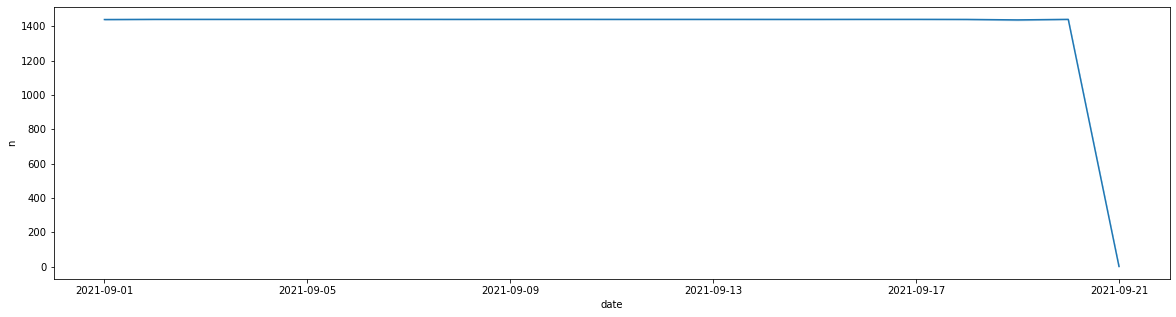

In [27]:
plt.figure(figsize=(20, 5))
sns.lineplot('date', 'n', data=rows_per_day)

- normally we get between 1400 and 1000 points daily obs for each crypto
-  theres a point near the end of 2019, that we have less than 800, for most of the cryptos, we could see if this affect the target
- the last day only have 21 obs, that the drop at the end of the figure
- after 2021 mostly (a little bit sooner), we got near 1400 per day, no missing values in this case

In [28]:
mean_of_rows = rows_per_day.groupby('date')['n'].mean().sort_values()

In [29]:
mean_of_rows.head(10)

date
2021-09-21       1.000000
2021-09-19    1436.857143
2021-09-01    1439.000000
2021-09-18    1439.642857
2021-09-15    1439.785714
2021-09-14    1439.857143
2021-09-12    1439.928571
2021-09-13    1439.928571
2021-09-11    1439.928571
2021-09-08    1439.928571
Name: n, dtype: float64

normaly we got over 1000 obs per day, except for 2019-10-16, what happened that day?
did it affect the target?
nothing on google so far, we do not how theses missing values affect the target

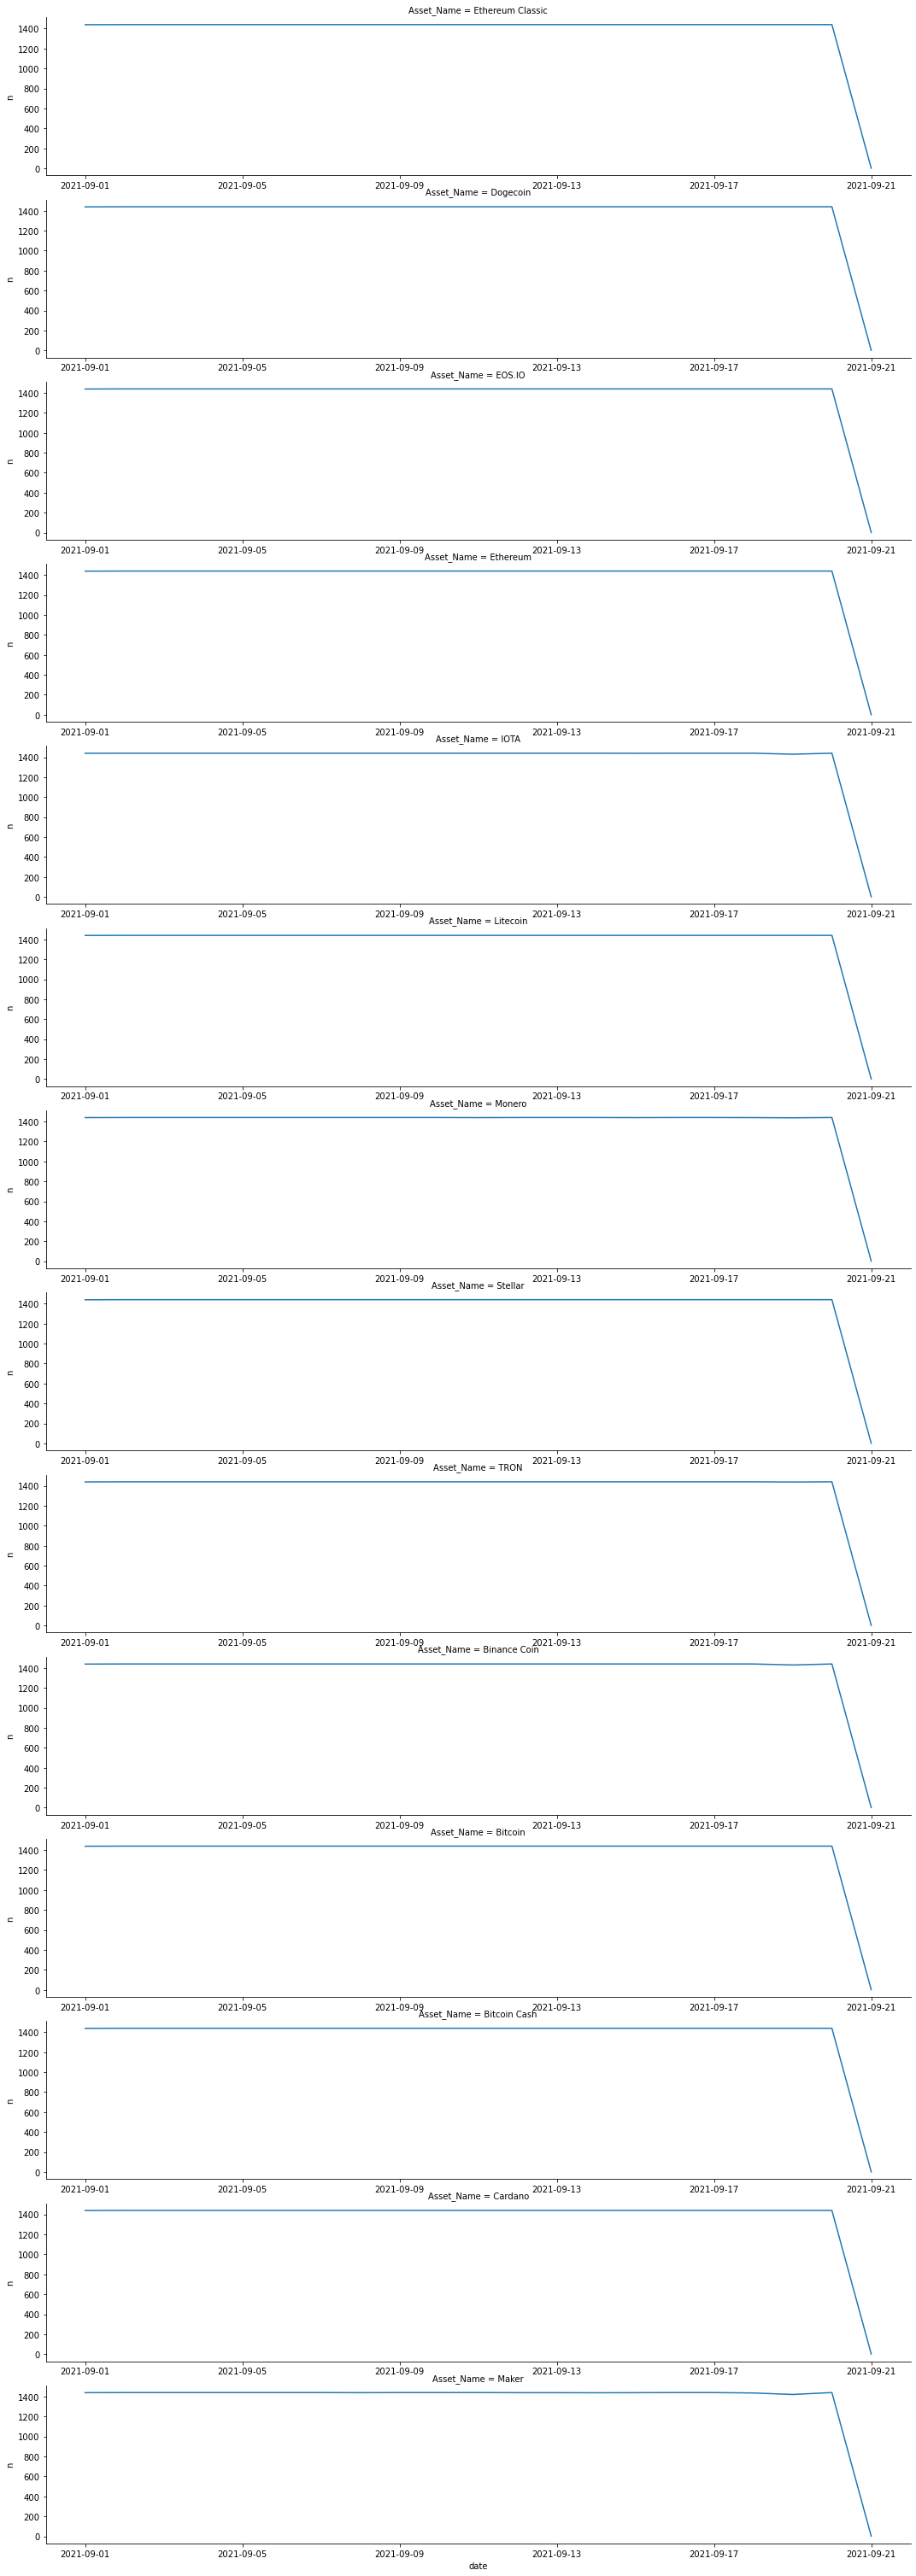

In [30]:
g = sns.FacetGrid(rows_per_day, row='Asset_Name', aspect=5)
g.map(sns.lineplot, 'date', 'n')
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)

- most of the cryptos are stable after near 2021-01
- Bitcoin, Ethereum (and Classic),  EOS.IO, TRON, litecoin are stable most of the time
- Dogecoin was the lastest release
- maker has value nears 0 until 2020-07, what happened there? after that, it is stable 
- all the coins were affect in 2019-10-16 in the same way (some signals like cardano started to variate before the day)

# target distribution 

In [18]:
TARGET = 'Target'
# the target describe the log return in the next 15 min

In [19]:
raw_df[TARGET].describe()

count    402821.000000
mean         -0.000002
std           0.003982
min          -0.066437
25%          -0.001415
50%          -0.000081
75%           0.001253
max           0.211227
Name: Target, dtype: float64

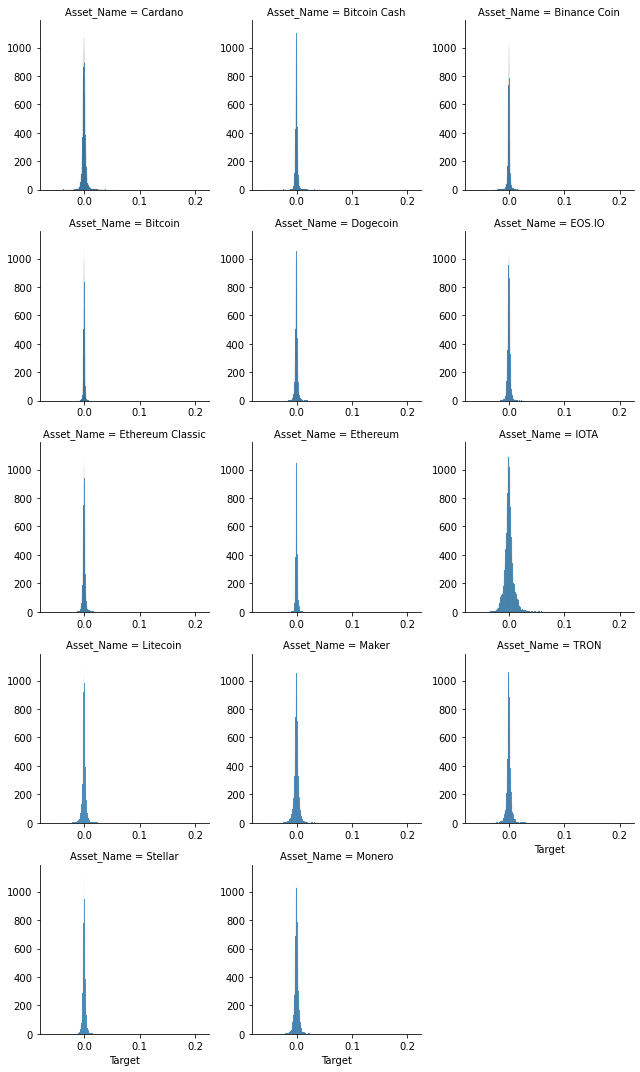

In [20]:
g = sns.FacetGrid(raw_df, col='Asset_Name', col_wrap=3,
                  sharex=True, sharey=True)
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True, labelleft=True)
g.map(sns.histplot, TARGET)

<AxesSubplot:xlabel='Asset_Name', ylabel='Target'>

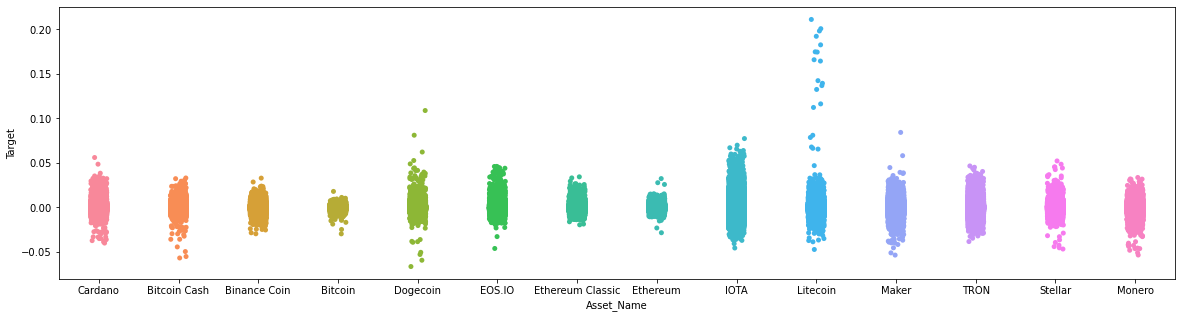

In [21]:
plt.figure(figsize=(20, 5))
sns.stripplot(x='Asset_Name', y=TARGET, data=raw_df)

In [22]:
crypto_stats = raw_df.groupby('Asset_Name')[TARGET].describe()

In [23]:
crypto_stats.style.background_gradient(cmap="viridis")

,count,mean,std,min,25%,50%,75%,max
Asset_Name,,,,,,,,
Binance Coin,28763.000000,-0.000098,0.002434,-0.029632,-0.001025,-0.000055,0.000885,0.032926
Bitcoin,28784.000000,-0.000010,0.001373,-0.029707,-0.000727,-0.000028,0.000669,0.017982
Bitcoin Cash,28784.000000,-0.000002,0.002585,-0.056814,-0.001142,-0.000071,0.000998,0.033089
Cardano,28784.000000,-0.000035,0.003672,-0.040053,-0.001683,-0.000194,0.001326,0.056079
Dogecoin,28784.000000,-0.000042,0.003126,-0.066437,-0.001285,-0.000133,0.001005,0.108882
EOS.IO,28784.000000,0.000055,0.003347,-0.046133,-0.001472,-0.000095,0.001309,0.046071
Ethereum,28784.000000,-0.000010,0.001943,-0.028447,-0.001037,-0.000050,0.000959,0.032393
Ethereum Classic,28784.000000,-0.000020,0.002597,-0.019551,-0.001247,-0.000098,0.001066,0.034354
IOTA,28760.000000,0.000242,0.008136,-0.045611,-0.003787,-0.000195,0.003545,0.077377


all data 
- not all cryptos has the same amount of data, the target has missing values
    - most missing cryto is Maker
- distribution are center at 0 (as expected)
- Ethereum Classic is the most volatil crypto, having the largest std max and min values
- Bitcoin volatil crypto, having the smallest std max and min values

2021 
- not all cryptos has the same amount of data, the target has missing values
    - most missing cryto is Maker
- doge coin is the most voltail with higest std, min and max values

In [24]:
daily_agg = raw_df.groupby([raw_df['timestamp'].dt.date, 'Asset_Name'])[TARGET].sum()

In [25]:
daily_agg = daily_agg.reset_index()

In [26]:
crypto_table = daily_agg.pivot('timestamp', 'Asset_Name', TARGET)

In [27]:
crypto_table.head()

Asset_Name,Binance Coin,Bitcoin,Bitcoin Cash,Cardano,Dogecoin,EOS.IO,Ethereum,Ethereum Classic,IOTA,Litecoin,Maker,Monero,Stellar,TRON
timestamp,,,,,,,,,,,,,,
2021-09-01,-0.071822,-0.103646,-0.212241,-0.370477,-0.054986,-0.166767,0.600520,0.004302,1.387770,-0.150765,-0.327938,0.890882,-0.339844,0.269501
2021-09-02,-0.408607,-0.030061,0.119300,0.306750,-0.149415,-0.356060,-0.345871,-0.486220,4.381413,-0.028373,-0.838049,-0.045757,0.011190,0.511867
2021-09-03,-0.270954,-0.155775,0.593639,-0.427413,-0.534125,0.923500,0.097769,-0.087332,-0.345137,1.775542,0.066348,-0.342714,-0.103669,-0.154991
2021-09-04,0.242623,-0.019164,-0.062712,-0.630974,0.147942,-0.178220,-0.215580,-0.163940,3.341932,-0.033123,-0.466062,-0.006689,0.091609,0.049950
2021-09-05,-0.210743,0.106072,0.466514,-0.134542,0.108169,0.509526,-0.240841,0.152503,-1.858238,0.266921,0.209150,0.059614,0.373026,-0.014671


<AxesSubplot:xlabel='timestamp', ylabel='Target'>

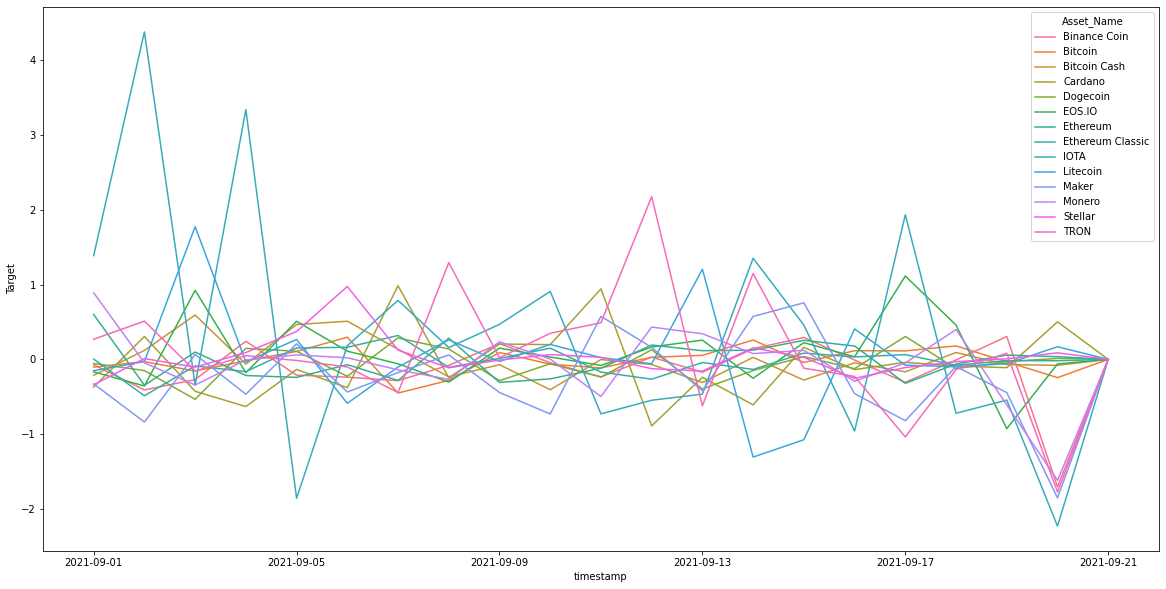

In [28]:
plt.figure(figsize=(20, 10))
sns.lineplot(x='timestamp', y=TARGET, data=daily_agg, hue='Asset_Name')

In [29]:
corr_matrix = crypto_table.corr()

<AxesSubplot:xlabel='Asset_Name', ylabel='Asset_Name'>

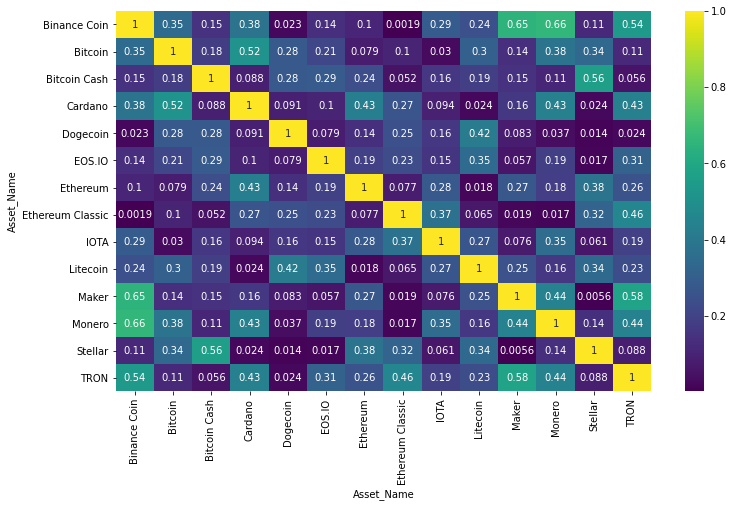

In [30]:
plt.figure(figsize=(12, 7))
sns.heatmap(corr_matrix.abs(), annot=True, cmap='viridis')

In [31]:
monthly_corr = crypto_table.groupby(pd.to_datetime(crypto_table.index).month).corr().stack()

monthly_corr.index.names = ['timestamp', 'A', 'B']

In [32]:
monthly_corr = monthly_corr.to_frame('corr').reset_index()

In [33]:
import itertools
combinations = list(itertools.combinations(raw_df['Asset_Name'].unique(), 2))

/tmp/ipykernel_5090/847719780.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(1, 1)


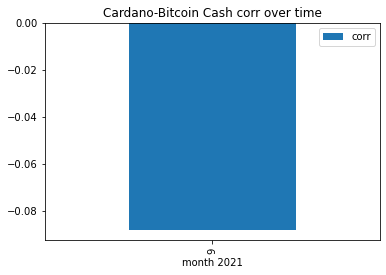

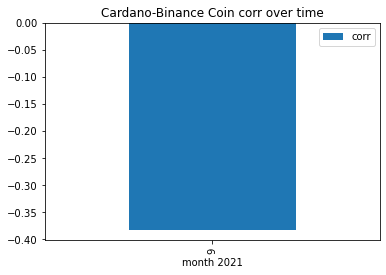

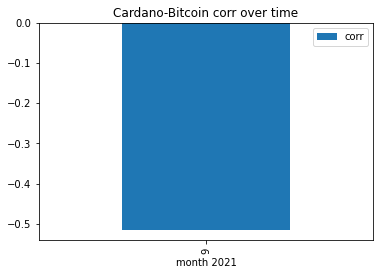

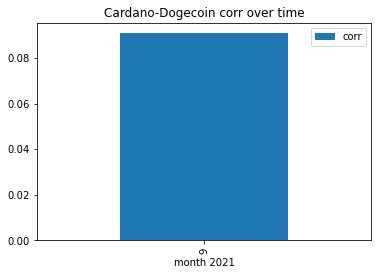

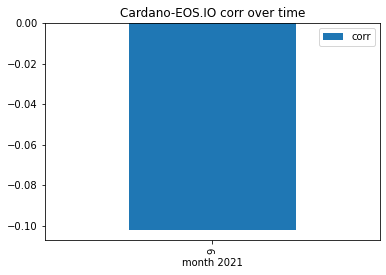

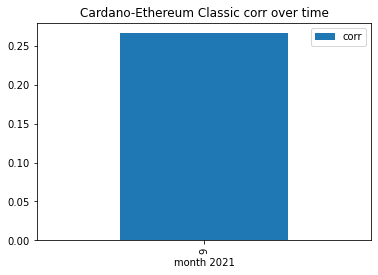

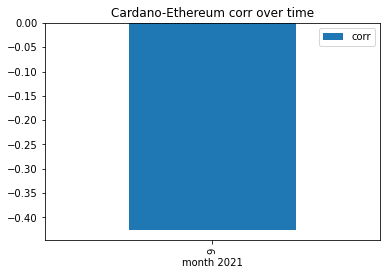

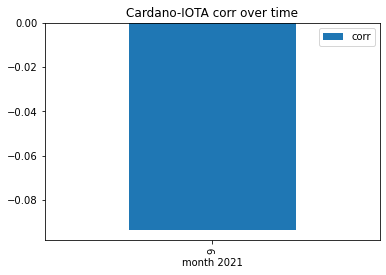

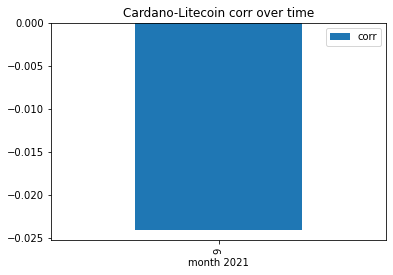

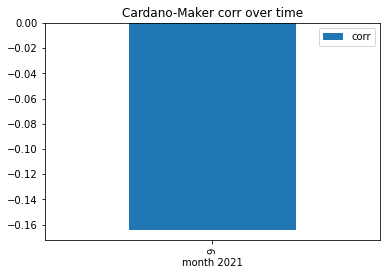

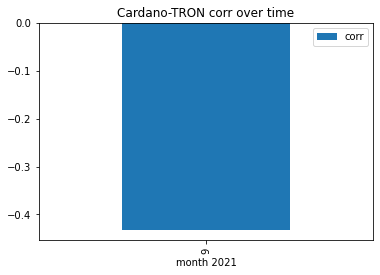

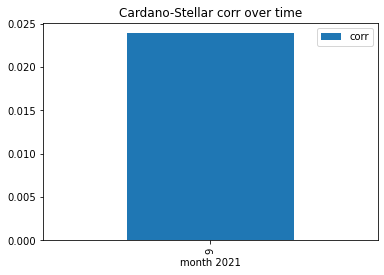

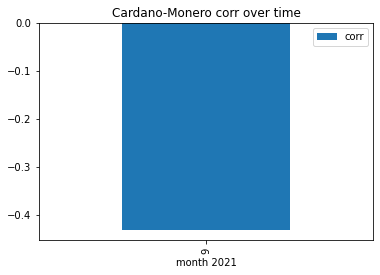

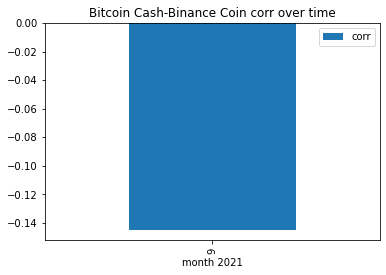

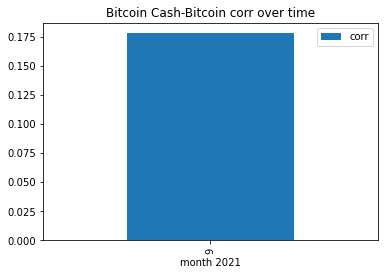

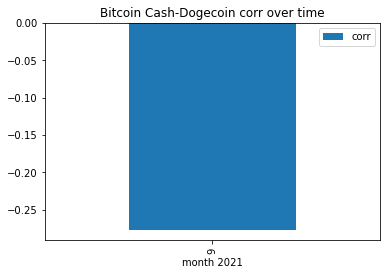

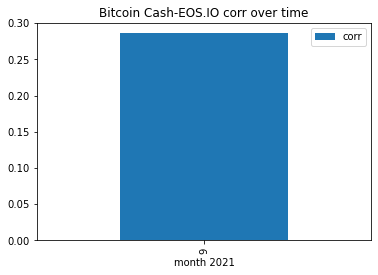

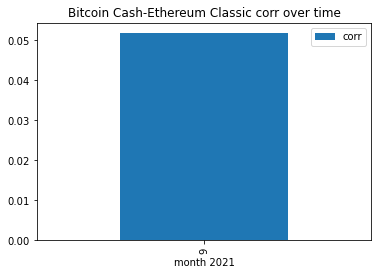

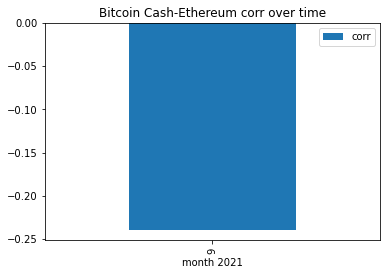

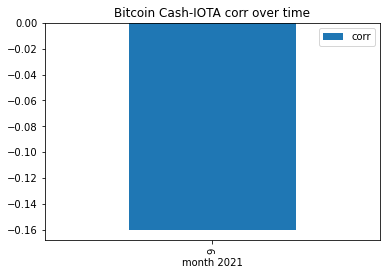

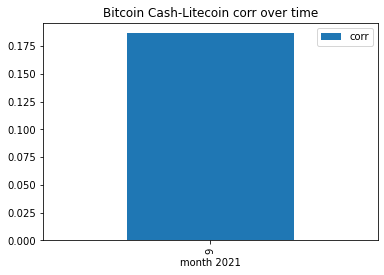

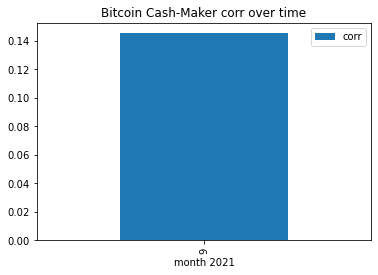

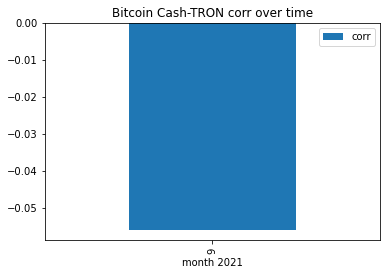

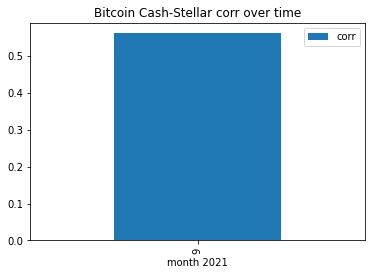

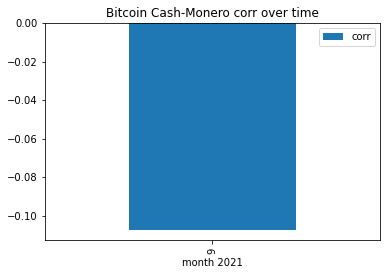

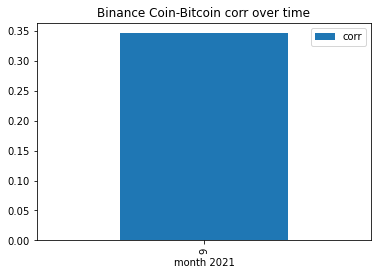

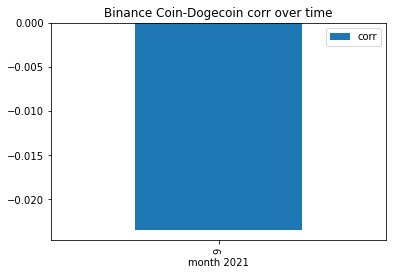

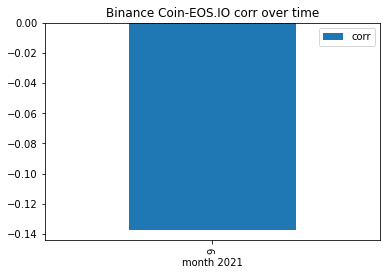

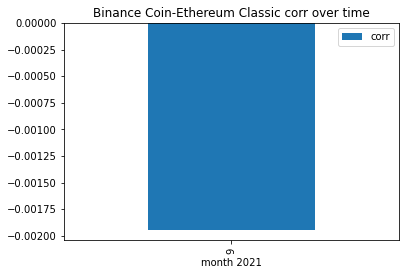

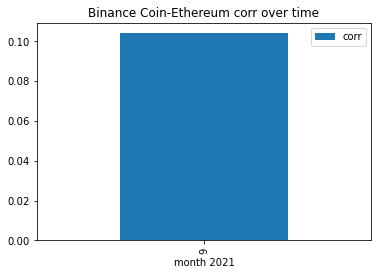

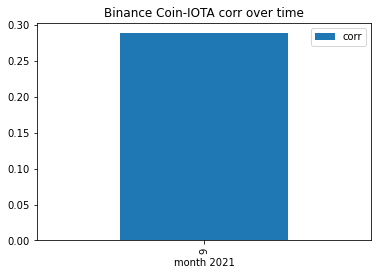

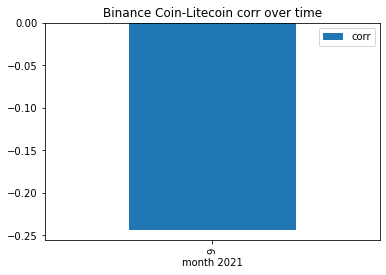

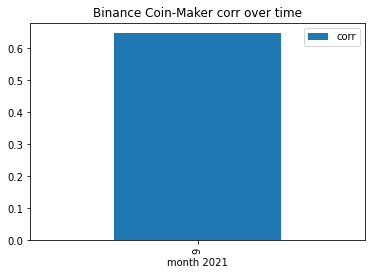

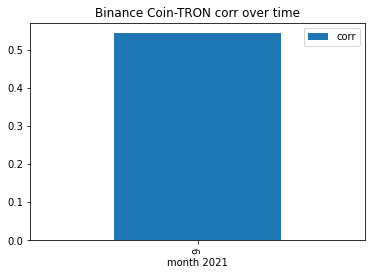

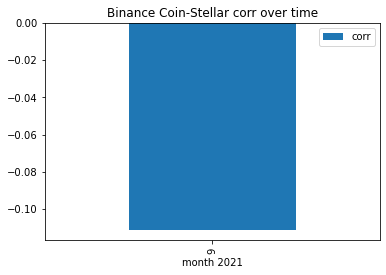

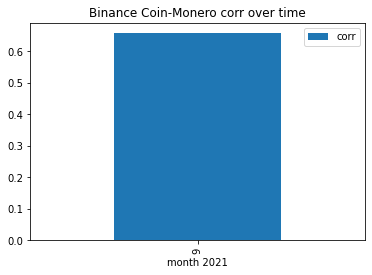

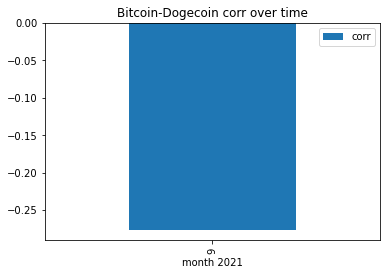

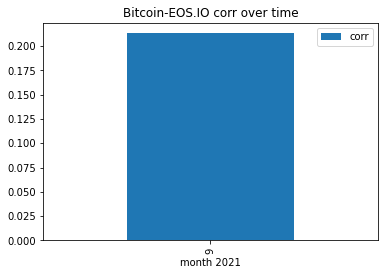

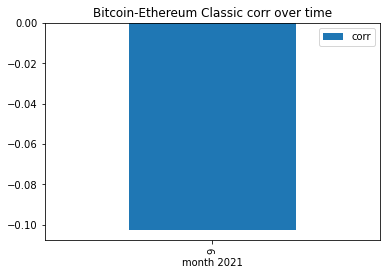

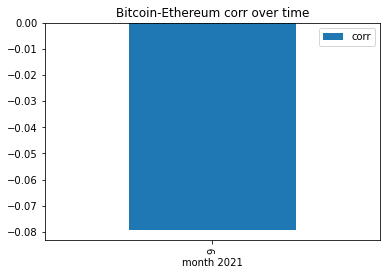

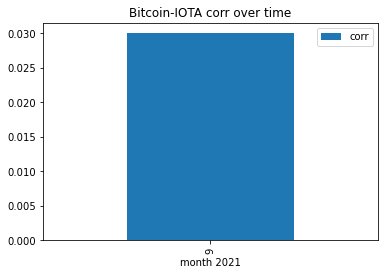

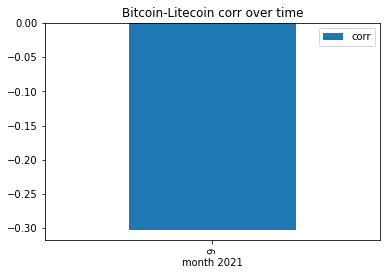

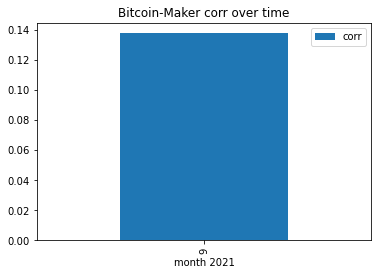

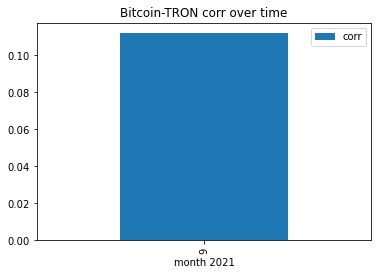

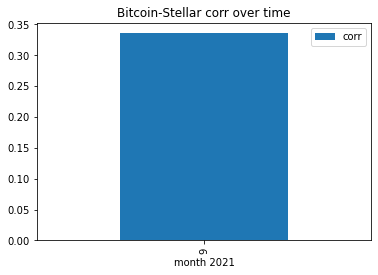

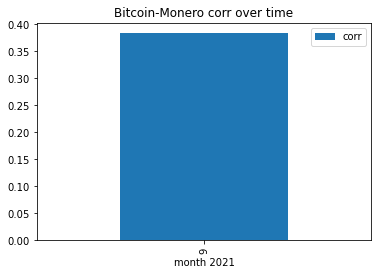

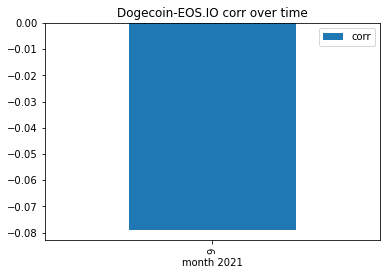

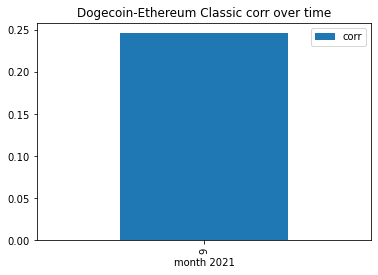

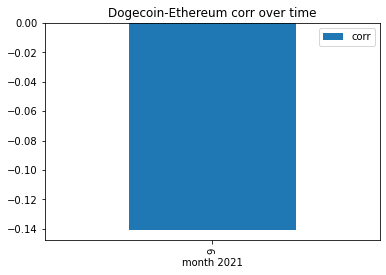

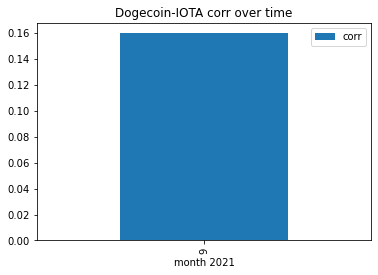

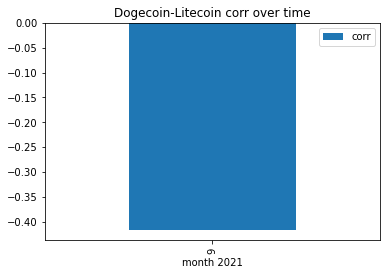

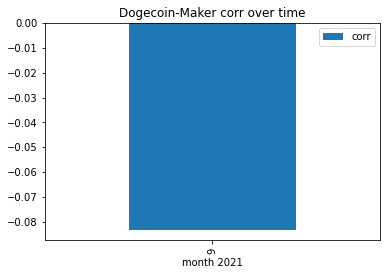

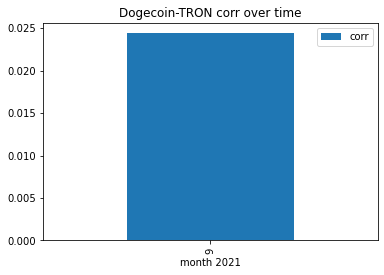

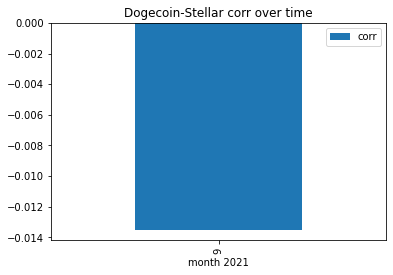

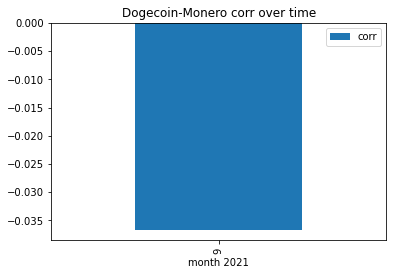

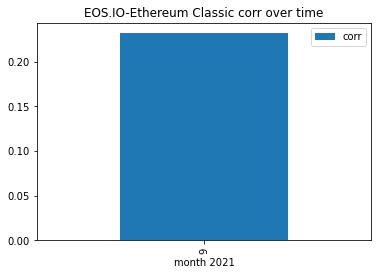

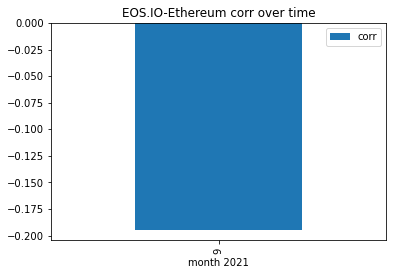

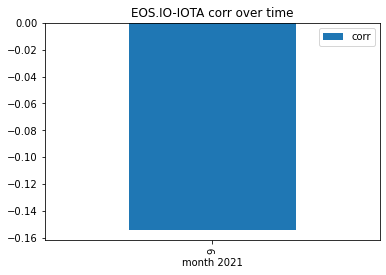

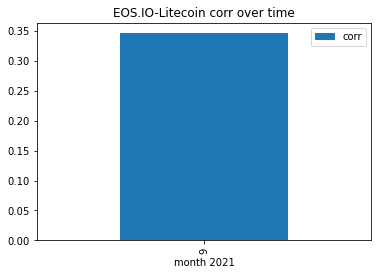

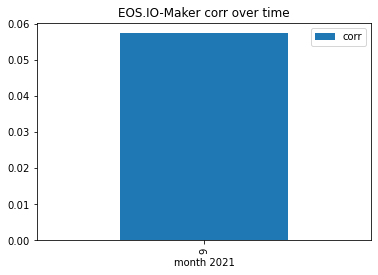

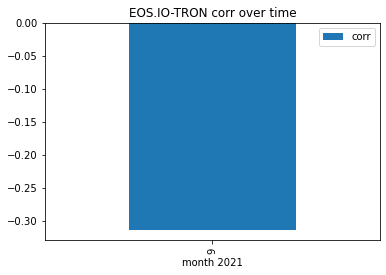

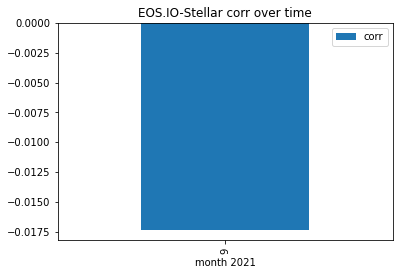

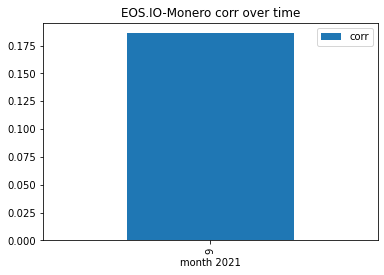

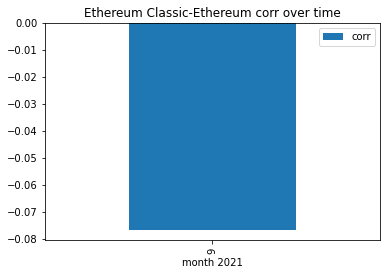

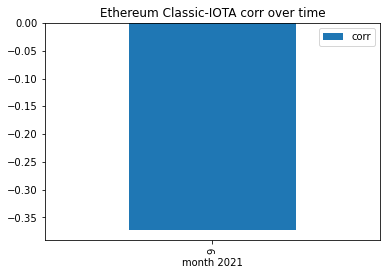

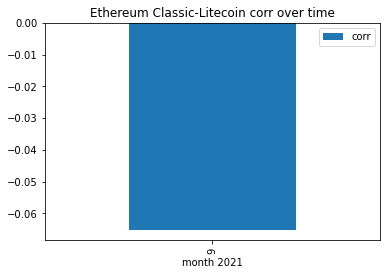

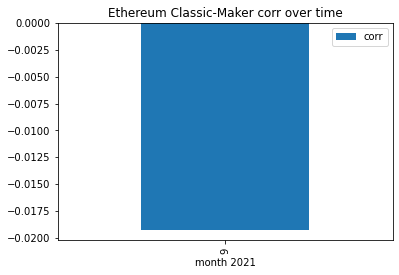

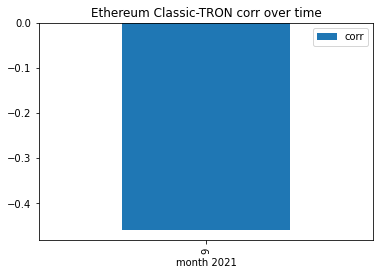

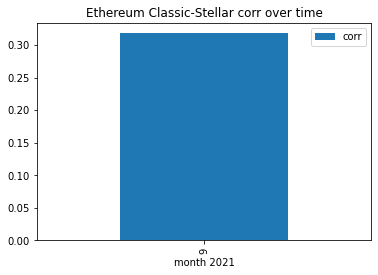

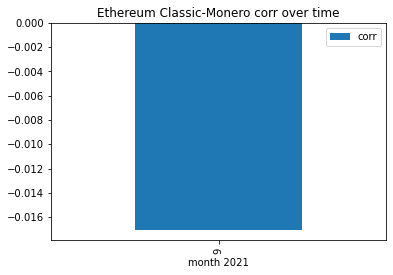

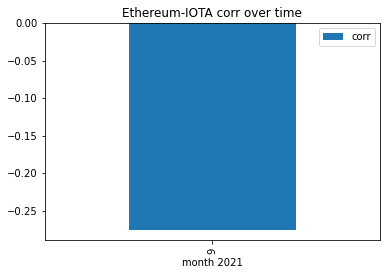

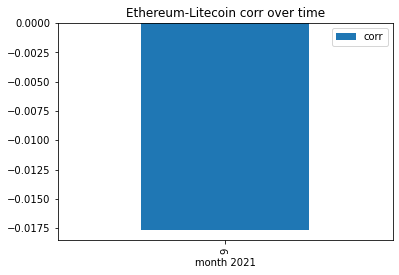

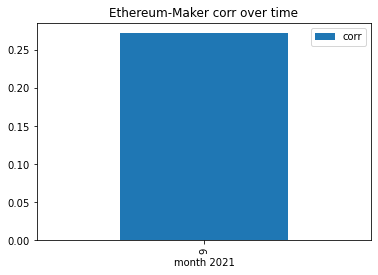

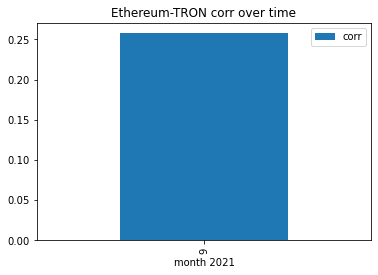

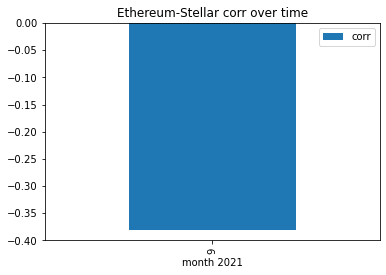

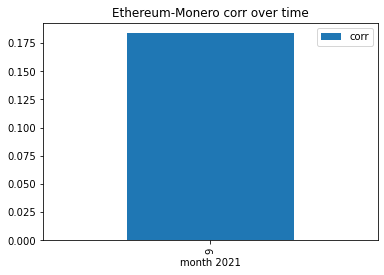

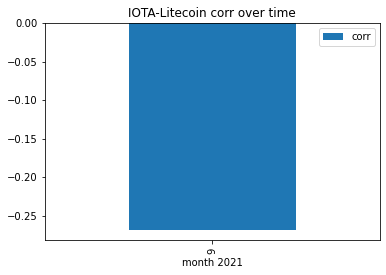

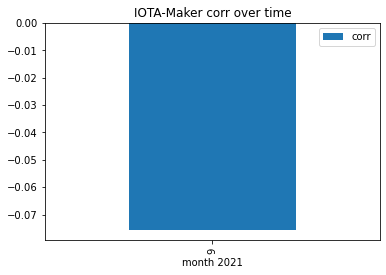

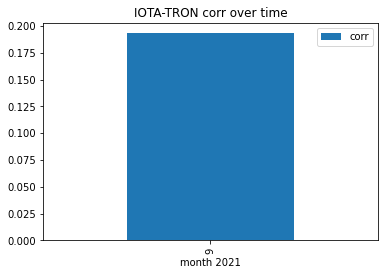

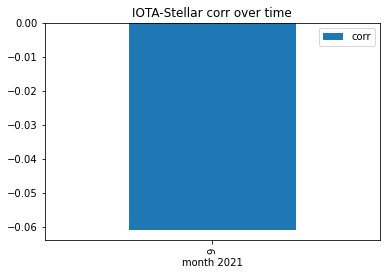

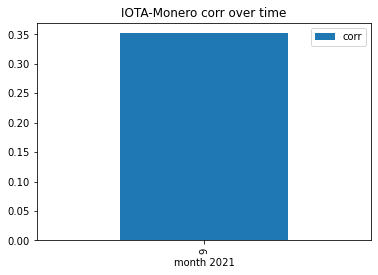

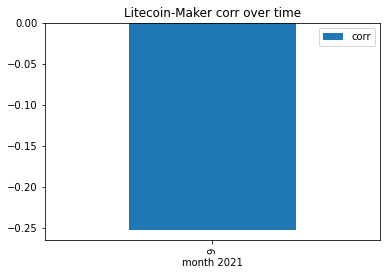

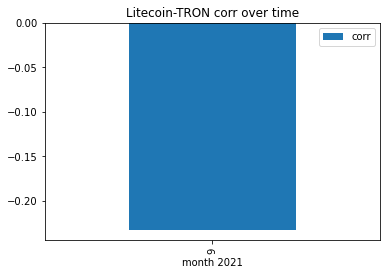

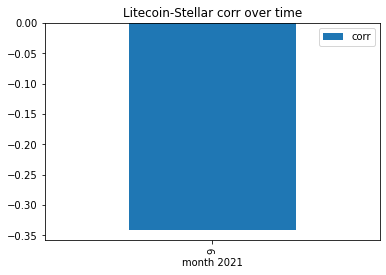

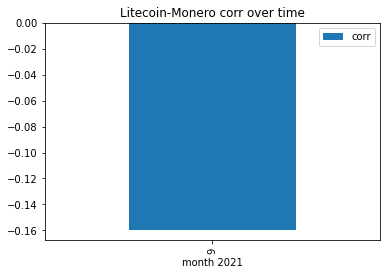

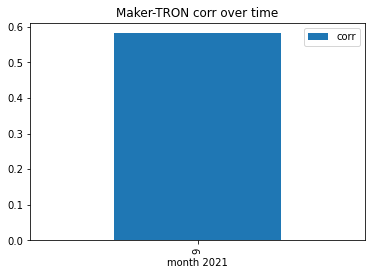

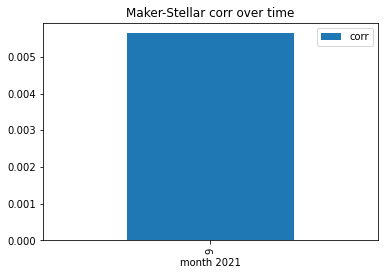

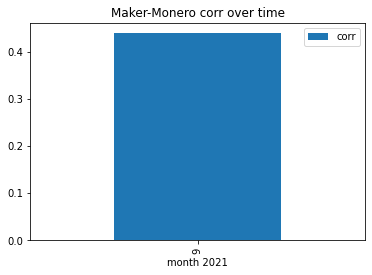

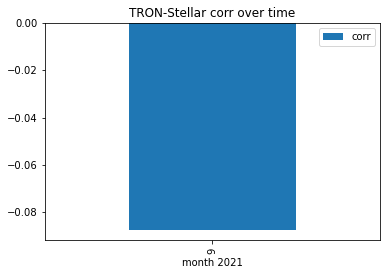

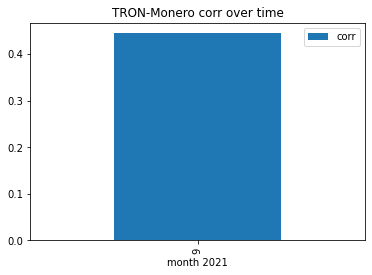

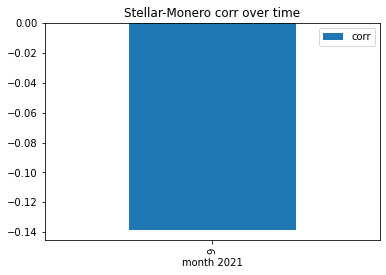

In [34]:
for A, B in combinations:
    f, ax = plt.subplots(1, 1)
    monthly_corr.query(f"A == '{A}' & B == '{B}'").plot.bar('timestamp', 'corr', ax=ax)
    ax.set_title(f'{A}-{B} corr over time')
    ax.set_xlabel('month 2021')

# FEATURES 

In [38]:
raw_df.sort_values(['Asset_ID', 'timestamp'])

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,Asset_Name
2,2021-09-01 00:01:00,0,373.0,462.223511,463.300995,462.200012,463.005493,8.652694e+02,462.689636,0.002667,Binance Coin
16,2021-09-01 00:02:00,0,772.0,462.939514,463.106995,461.000000,461.312988,1.723852e+03,461.899841,0.002237,Binance Coin
30,2021-09-01 00:03:00,0,864.0,461.265503,461.330994,459.799988,460.632507,2.172707e+03,460.532562,0.001018,Binance Coin
44,2021-09-01 00:04:00,0,419.0,460.799500,463.000000,460.600006,462.755005,1.050009e+03,461.469299,0.001898,Binance Coin
58,2021-09-01 00:05:00,0,1215.0,462.825989,465.399994,462.726013,465.266998,3.102897e+03,463.948822,0.001000,Binance Coin
...,...,...,...,...,...,...,...,...,...,...,...
403083,2021-09-20 23:56:00,13,477.0,0.091435,0.091500,0.091120,0.091221,2.613704e+06,0.091340,NaN,TRON
403097,2021-09-20 23:57:00,13,980.0,0.091131,0.091195,0.090802,0.090863,4.991573e+06,0.090991,NaN,TRON
403111,2021-09-20 23:58:00,13,720.0,0.090853,0.090940,0.090740,0.090859,3.699102e+06,0.090838,NaN,TRON
403125,2021-09-20 23:59:00,13,686.0,0.090941,0.091450,0.090860,0.091326,3.241507e+06,0.091193,NaN,TRON
